## Implements the Bayes prediction for clicked and not clicked 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

p = sns.color_palette()

dtypes = {'display_id' : np.int32, 'ad_id': np.int32, 'clicked': np.int8}

## Where is our data?

In [2]:
dataDir = "data/"  # Directory where our data is stored

## Reads the training data from CSV file

In [3]:
dfTrain = pd.read_csv(dataDir + "clicks_train.csv", usecols=['display_id', 'ad_id', 'clicked'], dtype=dtypes)

## Calculate the count, sum, and mean for each ad. 

In [4]:
ad_likelihood = dfTrain.groupby('ad_id')['clicked'].agg(['count','sum','mean'])

ad_likelihood = ad_likelihood.rename(columns={'sum' : 'number of time this ad was clicked', 'mean' : 'P(ad_id|+)',
                                             'count' : 'number of times this ad appeared'})


## Calculate the number of ads in each display.

In [5]:
dfTrain['# ads in display'] = dfTrain.groupby('display_id')['ad_id'].transform('count')

ad_likelihood['# ads in display'] = dfTrain['# ads in display']

## Get global click ratio mean, # of displays, and # of ads

In [6]:
countTotAdsDisplayed = float(dfTrain.shape[0])
uniqueAds = float(len(dfTrain['ad_id'].unique()))
uniqueDisplays = float(len(dfTrain['display_id'].unique()))

print ('There are {:,d} unique ads in {:,d} unique displays for a total of {:,d} ads displayed'
       .format(int(uniqueAds), int(uniqueDisplays), int(countTotAdsDisplayed)))

meanClicked = dfTrain['clicked'].mean()
print ('Probability that an ad is clicked is = {:f}'.format(meanClicked))

There are 478,950 unique ads in 16,874,593 unique displays for a total of 87,141,731 ads displayed
Probability that an ad is clicked is = 0.193645


## Possible replacement for likelihood

### Use Bayes Law as the measure. So likelihood of being clicked given ad = ad_id

+ $P(+ \mid {ad\_id})$ = # ads with ad_id in the set of all clicked ads divided by total **[kyle - this should always be a very low number correct?]**
+ $P(+)$ = clicks divided by (clicks plus not clicks) **[kyle - agreed]**
+ $P(+ \mid {\neg{ad\_id}})$ = # clicks for all ads not ad_id ($\neg{ad\_id}$) over total **[kyle - This should be a very high number mostly? close to 1.0? Do you not just do (1 - $P(+ \mid {ad\_id})$) because this is just the negation?]** 
+ $P({\neg{ad\_id}})$ = # not ad_id over total ads (1 - frequency of ad_id) **[kyle - agreed]**

$\huge P(+ \mid {ad\_id}) = \frac{P({ad\_id} \ \mid \ +) \ \times \ P(+)}{ P({ad\_id} \ \mid \ +) \  \times \ P(+) \ + \ P(+ \ \mid \ \neg{ad\_id}) \times P(\neg{ad\_id})}$

## $P(+) = \frac{\text{# clicks}}{\text{# clicks} \ + \ \text{# not clicks}}$

In [7]:
clicks = dfTrain.groupby('clicked').count()
totClicks = float(clicks.values[1][1])  # Total number of ads that were clicked
totNonClicks = float(clicks.values[0][0]) # Total number of ads that were not clicked
totEvents = totClicks + totNonClicks
Pclicked = totClicks / float(totEvents)
ad_likelihood['P(+)'] = Pclicked

## P(other ads) = 1 - # times this ad appeared / # of times all ads appeared
This is going to be 1.0 or nearly so since most ads only appear a few times. From Anokas' EDA (https://www.kaggle.com/anokas/outbrain-click-prediction/outbrain-eda) 97% of the ads appear in less than 1000 of the over 87 million ad displays. The most frequent ad was in 211K of the 87 million ad displays (0.243%)

In [8]:
ad_likelihood['P(other ads)'] = 1.0 - ad_likelihood['number of times this ad appeared'] / countTotAdsDisplayed

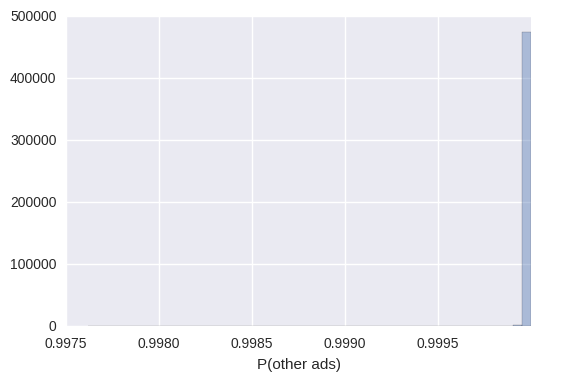

In [9]:
sns.distplot(ad_likelihood['P(other ads)'], kde=False);

## Not sure of this.

The conditional probability $P(B \mid A)$ is defined as $\large \frac{P(A \land B)}{P(A)}$

So $P(+ \mid \neg \text{ad}) = \large \frac{P(\neg \text{ad} \land +)}{P(+)}$

Therefore, I need to find the probability that other ads are clicked in the display and divide by the probability of the average ad being clicked.

Does that sound correct? **[kyle - I think for every other ad in the display you must find the probability of that ad being clicked then combine all of them, perhaps they are disjoint because we know not the order of ad being given to a user, so there are just all ads in front of the user and they must select one. In the table below shouldn't P(+|other ad) be of a value between 0-1?]**

In [10]:
ad_likelihood['P(+|other ad)'] = (1.0 - 1.0 / ad_likelihood['# ads in display']) / ad_likelihood['P(+)']
ad_likelihood.head(40)

,number of times this ad appeared,number of time this ad was clicked,P(ad_id|+),# ads in display,P(+),P(other ads),P(+|other ad)
ad_id,,,,,,,
1,2,0.0,0.000000,6,0.193645,1.000000,4.303399
2,22,1.0,0.045455,6,0.193645,1.000000,4.303399
3,161,11.0,0.068323,6,0.193645,0.999998,4.303399
4,32,4.0,0.125000,6,0.193645,1.000000,4.303399
5,1,0.0,0.000000,6,0.193645,1.000000,4.303399
6,1,0.0,0.000000,4,0.193645,1.000000,3.873059
7,3406,985.0,0.289196,4,0.193645,0.999961,3.873059
8,28,4.0,0.142857,4,0.193645,1.000000,3.873059
9,3,0.0,0.000000,4,0.193645,1.000000,3.873059


## Now put everything together

In [11]:
ad_likelihood['likelihood'] = (ad_likelihood['P(ad_id|+)'] * ad_likelihood['P(+)']) / \
                              ((ad_likelihood['P(ad_id|+)'] * ad_likelihood['P(+)']) + \
                              ad_likelihood['P(+|other ad)'] * ad_likelihood['P(other ads)'])
ad_likelihood.head()

,number of times this ad appeared,number of time this ad was clicked,P(ad_id|+),# ads in display,P(+),P(other ads),P(+|other ad),likelihood
ad_id,,,,,,,,
1,2,0.0,0.000000,6,0.193645,1.000000,4.303399,0.000000
2,22,1.0,0.045455,6,0.193645,1.000000,4.303399,0.002041
3,161,11.0,0.068323,6,0.193645,0.999998,4.303399,0.003065
4,32,4.0,0.125000,6,0.193645,1.000000,4.303399,0.005593
5,1,0.0,0.000000,6,0.193645,1.000000,4.303399,0.000000


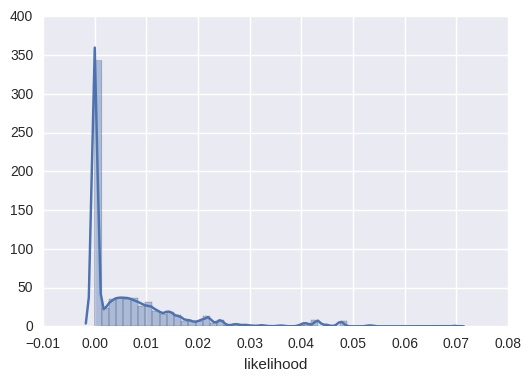

In [12]:
sns.distplot(ad_likelihood['likelihood']);

In [23]:
ad_likelihood = ad_likelihood.reset_index()

In [28]:
ad_likelihood = ad_likelihood[['ad_id', 'likelihood']]

## Read the test data

In [29]:
del dfTrain  # free up memory

In [30]:
dfTest = pd.read_csv(dataDir + "clicks_test.csv")

## Add the ad_likelihood to the test data

In [31]:
ad_likelihood = ad_likelihood.reset_index()  # Bring the ad_id back into the columns
dfTest = dfTest.merge(ad_likelihood, how='left', on='ad_id')

In [32]:
dfTest.head()

,display_id,ad_id,index,likelihood
0,16874594,66758,60180.0,0.003295
1,16874594,150083,132990.0,0.003048
2,16874594,162754,144273.0,0.010649
3,16874594,170392,151292.0,0.017176
4,16874594,172888,153545.0,0.015171


## Replace any NaNs with the global mean

**[do we know how many NANs there are and if so to which ad_id. This method of imputation can really kill the variance. Especially because so many ad_ids have so little occurances in the data set. This can mask many potential patterns.]**

In [33]:
dfTest['likelihood'].fillna(meanClicked, inplace=True)

## Rearrange the table sorting the ads based on likelihood. This gives us the ad order.

In [34]:
dfTest.sort_values(['display_id','likelihood'], inplace=True, ascending=False)

## Now just combine rows of the dataframe so that the ads and listed after each display_id. 

In [35]:
subm = dfTest.groupby('display_id')['ad_id'].apply(lambda x: " ".join(map(str,x))).reset_index()

In [36]:
subm.head()

,display_id,ad_id
0,16874594,170392 172888 162754 66758 150083 180797
1,16874595,8846 143982 30609
2,16874596,11430 289915 132820 289122 57197 153260 173005...
3,16874597,305790 285834 143981 182039 155945 180965 1378...
4,16874598,145937 335632 67292 250082


In [37]:
subm.to_csv(dataDir + "submissionBayes.csv", header=True, index=False)